In [55]:
# Python modules.
import os
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../data")


# Other modules.
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import (
    root_mean_squared_error,
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns


# Library.
from src.utils import (
    prepare_submission,
    submit_file,
    get_submission_scores,
)
from src.eda import (
    distplot,
    correlation_heatmap,
    draw_count_plot_to_study_features,
    compare_predictions_and_real_values,
)
from src.preprocessing import (
    fill_df_navalues,
    scale_and_encoder_features,
    split_X_y_in_train_test_sets,
)

In [164]:
# Loading data
df_train = pd.read_csv("data/train.csv")
#     pd.read_csv("data/training_extra.csv")
# ])
print(df_train.shape)
df_test = pd.read_csv("data/test.csv")
column_names = df_train.drop(columns=["id", "Price"]).columns

(300000, 11)


### EDA

In [165]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [166]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 193773 non-null  object 
 2   Material              194387 non-null  object 
 3   Size                  195619 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    195038 non-null  object 
 6   Waterproof            195189 non-null  object 
 7   Style                 194847 non-null  object 
 8   Color                 193215 non-null  object 
 9   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


<Figure size 1900x1000 with 0 Axes>

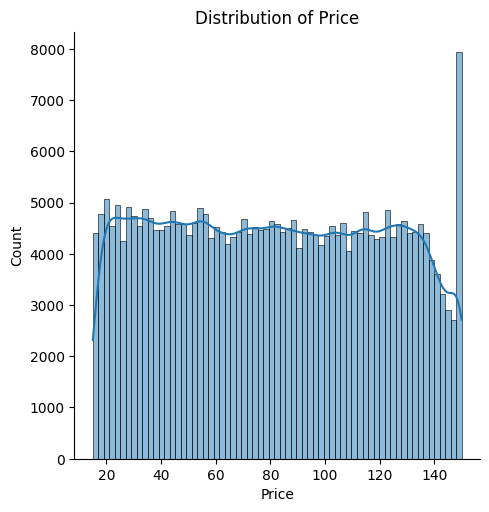

<Figure size 1900x1000 with 0 Axes>

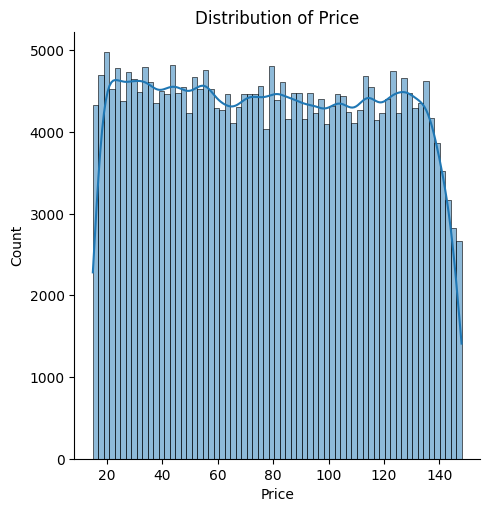

In [167]:
distplot(df=df_train, variable_name="Price")
df_train = df_train.drop(df_train[df_train.Price >= 148].index)
distplot(df=df_train, variable_name="Price")

<Figure size 1900x1000 with 0 Axes>

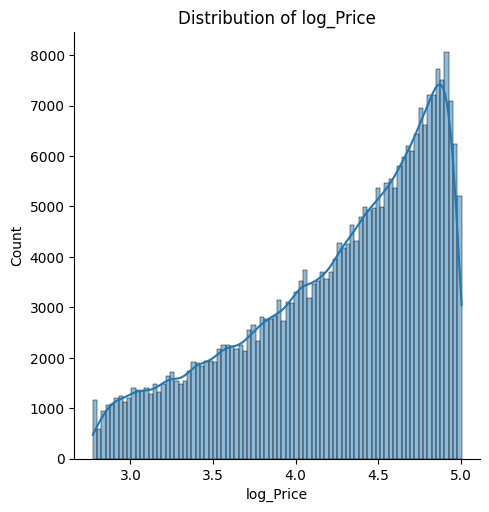

In [168]:
# quan = QuantileTransformer(output_distribution="normal", n_quantiles=200)
df_train["log_Price"] = np.log1p(df_train.Price)
distplot(df=df_train, variable_name="log_Price")
# df_train["reverse_log_Price"] = np.expm1(df_train.log_Price)
# distplot(df=df_train, variable_name="reverse_log_Price")

### Studying features.

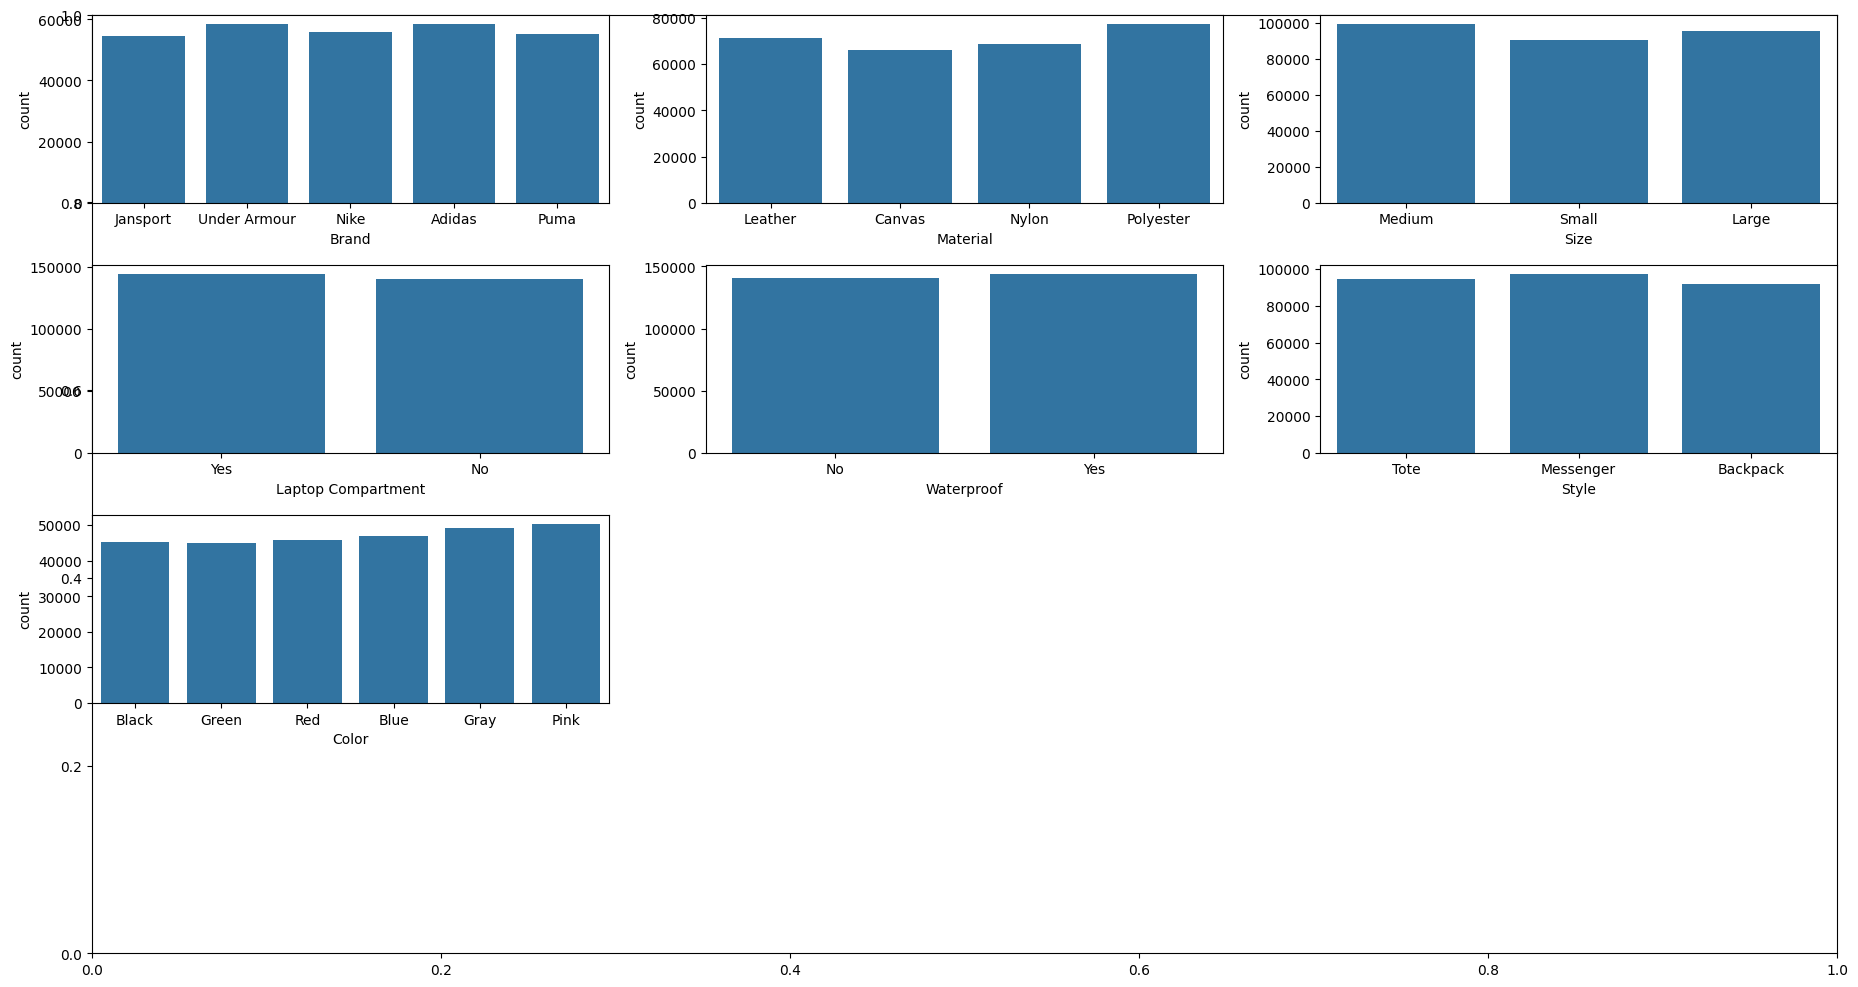

In [169]:
draw_count_plot_to_study_features(df=df_train)

After studying a bit the features, it appears to me that there is no fundamentall distinction between featrues. They do not seems to impact the price so much. Every time I make computation and get the mean price depending on Style, Material or whatever, I ended up having a 80-82 mean pricce.

Useless.

In [170]:
df_train.groupby(["Brand", "Material", "Style"]).agg({"Price": "mean"})

Price
Brand        Material  Style               
Adidas       Canvas    Backpack   80.177181
                       Messenger  79.696957
                       Tote       79.353077
             Leather   Backpack   77.360835
                       Messenger  78.499861
                       Tote       77.739010
             Nylon     Backpack   78.476916
                       Messenger  78.192475
                       Tote       78.429225
             Polyester Backpack   79.620091
                       Messenger  79.106818
                       Tote       79.337691
Jansport     Canvas    Backpack   80.597774
                       Messenger  79.888710
                       Tote       79.860924
             Leather   Backpack   79.795581
                       Messenger  78.406237
                       Tote       78.251865
             Nylon     Backpack   80.155606
                       Messenger  80.494467
                       Tote       80.135976
             Polyester Backpack   79.932703
                       Messenger  81.284701
                       Tote       79.772340
Nike         Canvas    Backpack   80.456004
                       Messenger  80.298682
                       Tote       80.131742
             Leather   Backpack   78.878888
                       Messenger  77.970079
                       Tote       78.704304
             Nylon     Backpack   78.747992
                       Messenger  78.829747
                       Tote       78.931812
             Polyester Backpack   79.196476
                       Messenger  80.275489
                       Tote       81.036214
Puma         Canvas    Backpack   79.256525
                       Messenger  79.840290
                       Tote       80.860469
             Leather   Backpack   78.703960
                       Messenger  79.114670
                       Tote       77.945730
             Nylon     Backpack   79.403198
                       Messenger  78.551737
                       Tote       79.204223
             Polyester Backpack   79.901842
                       Messenger  79.858847
                       Tote       80.018195
Under Armour Canvas    Backpack   81.806133
                       Messenger  80.757720
                       Tote       80.903845
             Leather   Backpack   78.668663
                       Messenger  79.116402
                       Tote       79.804811
             Nylon     Backpack   79.916182
                       Messenger  79.753409
                       Tote       79.239757
             Polyester Backpack   81.450043
                       Messenger  81.091409
                       Tote       80.778706

## Preprocessing

In [171]:
# Preprocessing
df_train_filled = fill_df_navalues(df=df_train)
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292077 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 292077 non-null  object 
 1   Material              292077 non-null  object 
 2   Size                  292077 non-null  object 
 3   Compartments          292077 non-null  float64
 4   Laptop Compartment    292077 non-null  object 
 5   Waterproof            292077 non-null  object 
 6   Style                 292077 non-null  object 
 7   Color                 292077 non-null  object 
 8   Weight Capacity (kg)  292077 non-null  float64
 9   Price                 292077 non-null  float64
 10  log_Price             292077 non-null  float64
dtypes: float64(4), object(7)
memory usage: 26.7+ MB


In [172]:
# Scaling
df_train_filled_n, scalers_and_encoders = scale_and_encoder_features(df=df_train_filled)
df_train_filled_n.info()


<class 'pandas.core.frame.DataFrame'>
Index: 292077 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 292077 non-null  int64  
 1   Material              292077 non-null  int64  
 2   Size                  292077 non-null  int64  
 3   Compartments          292077 non-null  float64
 4   Laptop Compartment    292077 non-null  int64  
 5   Waterproof            292077 non-null  int64  
 6   Style                 292077 non-null  int64  
 7   Color                 292077 non-null  int64  
 8   Weight Capacity (kg)  292077 non-null  float64
 9   Price                 292077 non-null  float64
 10  log_Price             292077 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 26.7 MB


/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/

### Correlation matrix.

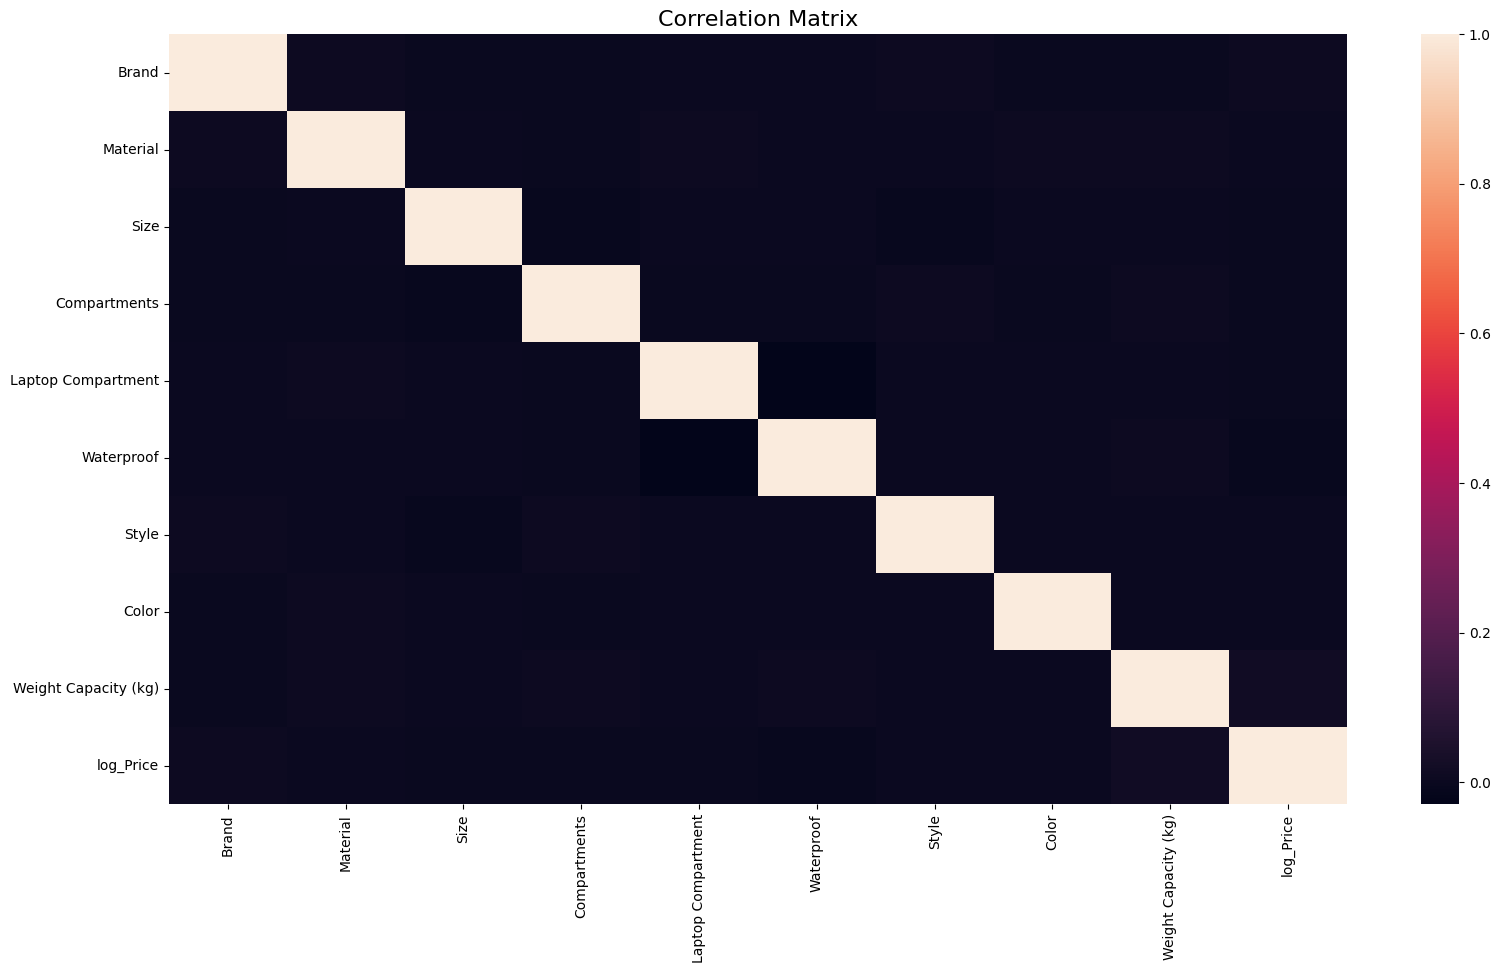

In [173]:
corr = (
    df_train_filled_n
    .select_dtypes(include=["float64", "int64"])
    .drop(columns=["Price", "id", "index"], errors='ignore')
    .corr()
)
correlation_heatmap(df_correlation=corr)

In [174]:
X = df_train_filled_n.loc[:, column_names]
y = df_train_filled_n.loc[:, ["log_Price"]]
X_train, X_test, y_train, y_test = split_X_y_in_train_test_sets(X=X, y=y)

In [175]:
model = LinearRegression()
model2 = RandomForestRegressor()
model.fit(X_train, y_train)
model2.fit(X_train, y_train)

/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [176]:
score = model2.score(X_test, y_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=model2.predict(X_test))
# intercept = model.intercept_
# coeff = model.coef_
print(f"Score: {score:.2f}") # vs {score_l:.2f} vs {score_rf:.2f}")
print(f"RMSE: {rmse:.2f}") # vs {rmse_l:.2f} vs {rmse_rf:.2f}")

Score: -0.06
RMSE: 0.27


In [177]:
X_test["log_Price_prediction"] = model2.predict(X_test[column_names])
X_test["log_Price"] = y_test.loc[:, ["log_Price"]]
X_test

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),log_Price_prediction,log_Price
169459,1,1,0,0.888889,2,2,2,0,0.360438,0.575405,0.652064
147970,3,2,2,0.000000,0,0,1,4,0.573445,0.667235,0.664462
170309,1,2,2,0.666667,0,2,1,5,0.631240,0.680022,0.888526
279045,0,1,2,0.222222,0,0,2,3,0.166667,0.750502,0.796163
274437,2,2,2,0.222222,2,2,2,2,0.492618,0.679625,0.788531
...,...,...,...,...,...,...,...,...,...,...,...
261460,4,0,3,0.888889,2,0,2,4,0.579858,0.618669,0.801012
275916,2,1,0,0.222222,2,2,0,4,0.791853,0.555566,0.354530
5254,1,2,1,0.666667,2,0,0,6,0.223971,0.614509,0.805894
165003,3,2,2,0.000000,2,0,1,3,0.657040,0.781223,0.815768


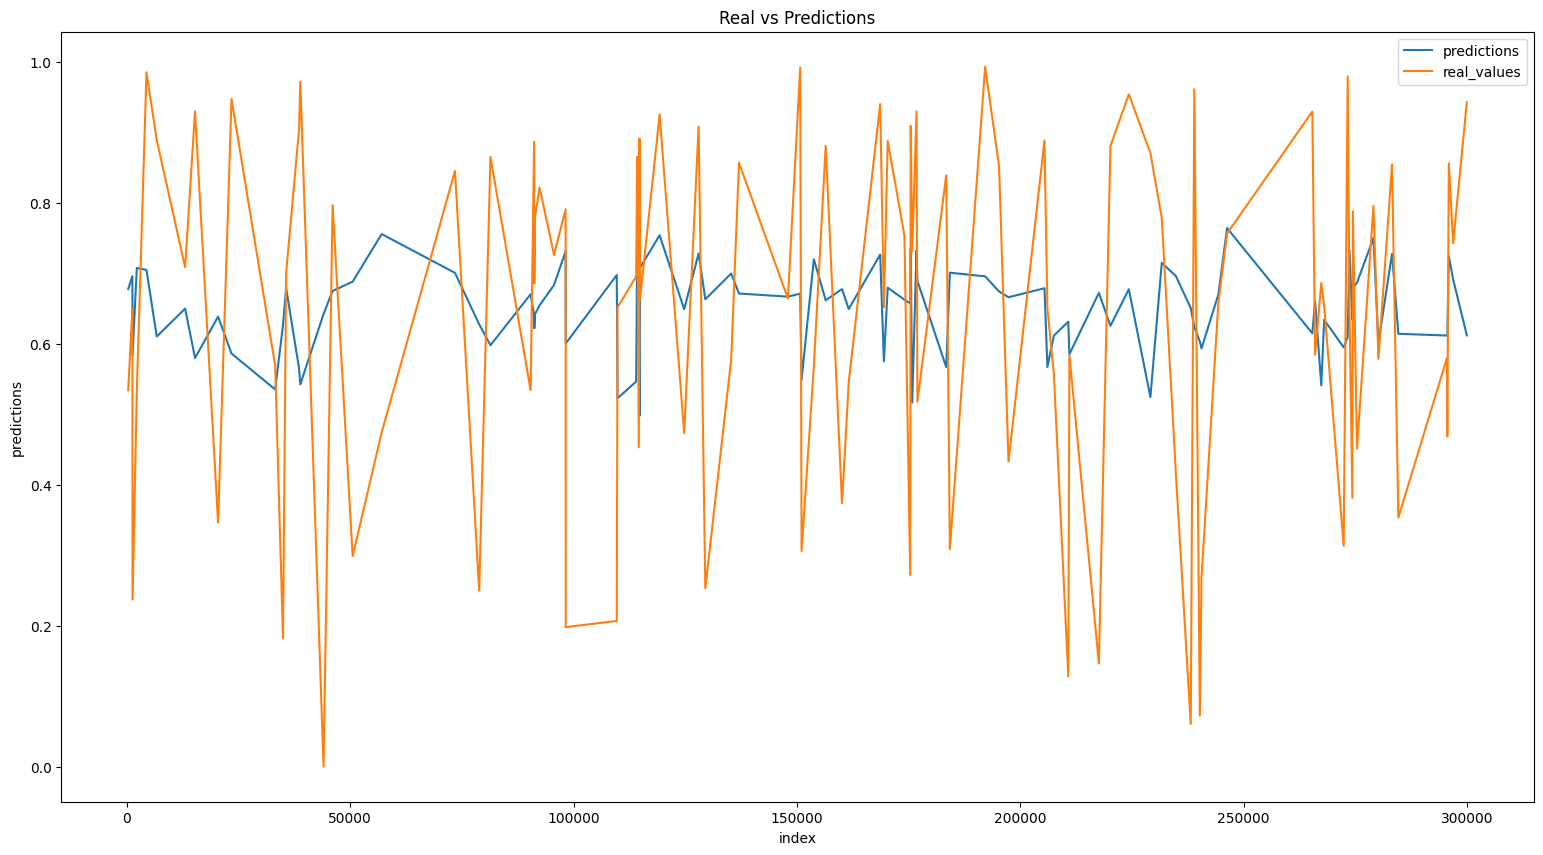

In [179]:
compare_predictions_and_real_values(
    df=X_test.loc[:, ["log_Price_prediction", "log_Price"]].rename(columns={
        "log_Price_prediction": "predictions",
        "log_Price": "real_values",
        }).reset_index().iloc[:100],
)

Linear regression is not a good model for this problem.

In [180]:
df_test_filled = fill_df_navalues(df=df_test)
df_test_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 200000 non-null  object 
 2   Material              200000 non-null  object 
 3   Size                  200000 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    200000 non-null  object 
 6   Waterproof            200000 non-null  object 
 7   Style                 200000 non-null  object 
 8   Color                 200000 non-null  object 
 9   Weight Capacity (kg)  200000 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


In [181]:
df_test_filled_n = df_test_filled.copy()
for column_name in df_test_filled_n.columns:
    if column_name == "id":
        continue
    df_test_filled_n[column_name] = (
        scalers_and_encoders[column_name]
        .transform(df_test_filled_n.loc[:, [column_name]])
    )

df_test_filled_n.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 200000 non-null  int64  
 2   Material              200000 non-null  int64  
 3   Size                  200000 non-null  int64  
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    200000 non-null  int64  
 6   Waterproof            200000 non-null  int64  
 7   Style                 200000 non-null  int64  
 8   Color                 200000 non-null  int64  
 9   Weight Capacity (kg)  200000 non-null  float64
dtypes: float64(2), int64(8)
memory usage: 15.3 MB


/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/Baptiste/Documents/swag2-backpack-predict/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, 

In [134]:
df_test_filled_n["log_Price_prediction"] = model2.predict(df_test_filled_n.loc[:, column_names])
df_test_filled_n["Price_prediction"] = scalers_and_encoders["log_Price"].inverse_transform(df_test_filled_n.loc[:, ["log_Price_prediction"]])
df_test_filled_n["Price_prediction_inv_quant"] = quan.inverse_transform(df_test_filled_n.rename(columns={"Price_prediction": "Price"}).loc[:, ["Price"]])
df_test_filled_n

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),normal_Price_prediction,Price_prediction,Price_prediction_inv_quant
0,300000,3,1,2,0.111111,0,0,2,3,0.689038,0.497734,-0.023564,77.796636
1,300001,2,0,1,0.666667,0,2,0,3,0.452137,0.480702,-0.200675,69.125128
2,300002,0,0,0,0.888889,0,2,1,1,0.393660,0.541098,0.427365,100.119839
3,300003,0,2,0,0.000000,2,0,1,3,0.615901,0.504866,0.050602,81.686581
4,300004,5,2,0,0.111111,2,2,2,0,0.330265,0.491140,-0.092130,74.215128
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,0,0,0,0.111111,2,0,1,5,0.246117,0.489695,-0.107158,73.474859
199996,499996,2,3,2,0.888889,0,2,1,4,0.201946,0.489462,-0.109581,73.364712
199997,499997,1,2,2,0.888889,0,2,2,3,0.896339,0.366648,-1.386686,25.380498
199998,499998,3,2,0,1.000000,2,0,2,2,0.858972,0.480780,-0.199857,69.172946


<Figure size 1900x1000 with 0 Axes>

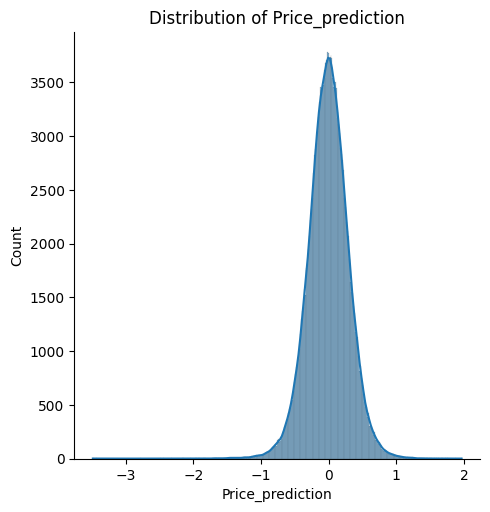

<Figure size 1900x1000 with 0 Axes>

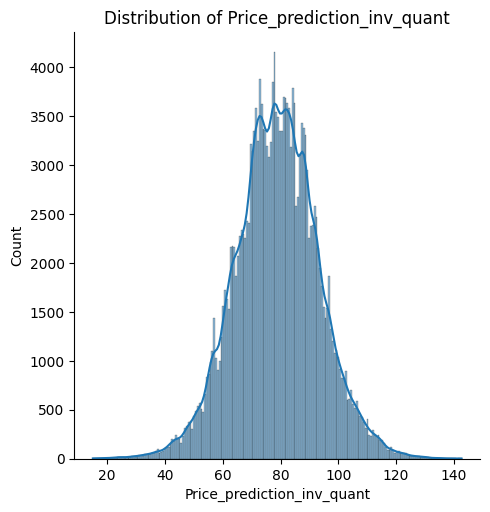

In [135]:
distplot(df=df_test_filled_n, variable_name="Price_prediction")
distplot(df=df_test_filled_n, variable_name="Price_prediction_inv_quant")

In [136]:
prepare_submission(df_predictions=df_test_filled_n.rename(columns={"Price_prediction_inv_quant": "prediction"}))

Generating output: data/my_submission.csv.


In [137]:
submit_file(message="Random forest")

Submitting data/my_submission.csv to competition:playground-series-s5e2


100%|██████████| 2.49M/2.49M [00:01<00:00, 2.14MB/s]


In [139]:
get_submission_scores()

Retrieving scores from competition:playground-series-s5e2
42831717 - 41.54405 -  - 2025-02-11 16:02:15
42830901 - 40.97361 -  - 2025-02-11 15:16:50
42770810 - 40.92468 -  - 2025-02-08 11:06:30
42753436 - 90.27426 -  - 2025-02-07 14:09:37
42753425 -  -  - 2025-02-07 14:08:43
42753373 -  -  - 2025-02-07 14:05:28
42751414 - 47.83047 -  - 2025-02-07 11:28:51
42751405 - 61.44125 -  - 2025-02-07 11:27:19
42751147 - 39.16456 -  - 2025-02-07 11:01:47
42751114 - 39.16456 -  - 2025-02-07 10:59:07
